In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
df = pd.read_csv(r"C:\Users\vedan\Downloads\ETERNAL10YR6_1_26 - Sheet1.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

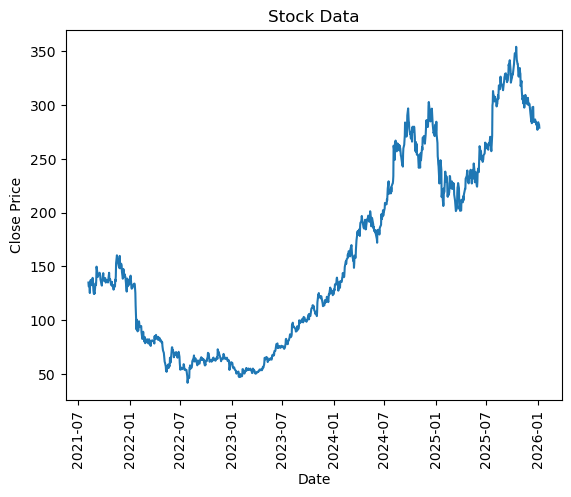

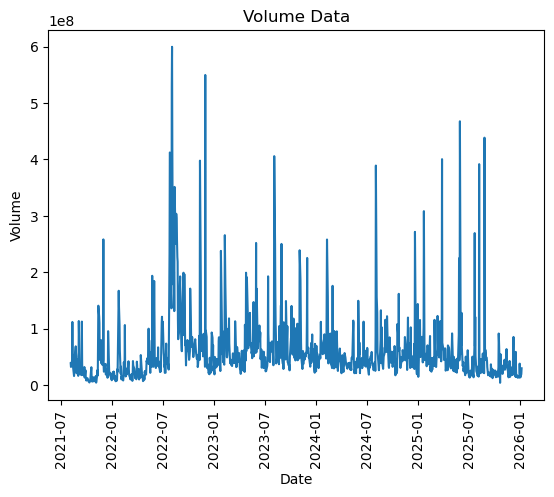

In [21]:
plt.figure()
plt.plot(df["Date"], df["Close"], label="Historical")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Close Price")
plt.title("Stock Data")
plt.show()
plt.figure()
plt.plot(df["Date"], df["Volume"], label="Volume")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Volume")
plt.title("Volume Data")
plt.show()

In [4]:
# Lag features
df["Close_lag1"] = df["Close"].shift(1)
df["Close_lag2"] = df["Close"].shift(2)
df["Close_lag3"] = df["Close"].shift(3)

# Rolling statistics
df["Close_ma5"] = df["Close"].rolling(5).mean()
df["Close_ma10"] = df["Close"].rolling(10).mean()

# Drop rows with NaNs caused by lags
df = df.dropna().reset_index(drop=True)

In [5]:
features = [
    "Open", "High", "Low", "Volume",
    "Close_lag1", "Close_lag2", "Close_lag3",
    "Close_ma5", "Close_ma10"
]

X = df[features]
y = df["Close"]

In [6]:
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.57
RMSE: 1.96


In [30]:
N_FUTURE_DAYS = 5

future_predictions = []
last_row = df.iloc[-1].copy()

for _ in range(N_FUTURE_DAYS):
    X_future = pd.DataFrame([last_row[features]])

    next_close = model.predict(X_future)[0]
    future_predictions.append(next_close)

    # Update lags and rolling values
    last_row["Close_lag3"] = last_row["Close_lag2"]
    last_row["Close_lag2"] = last_row["Close_lag1"]
    last_row["Close_lag1"] = next_close

    last_row["Close_ma5"] = (
        last_row["Close_ma5"] * 4 + next_close
    ) / 5

    last_row["Close_ma10"] = (
        last_row["Close_ma10"] * 9 + next_close
    ) / 10

    last_row["Close"] = next_close
    
    
future_dates = pd.date_range(
    start=df["Date"].iloc[-1],
    periods=N_FUTURE_DAYS + 1,
    freq="D"
)[1:]

In [18]:
for i, price in enumerate(future_predictions, 1):
    print(f"Day +{i} Predicted Close: {price:.2f}")

Day +1 Predicted Close: 278.10
Day +2 Predicted Close: 278.73
Day +3 Predicted Close: 279.44
Day +4 Predicted Close: 280.02
Day +5 Predicted Close: 279.57


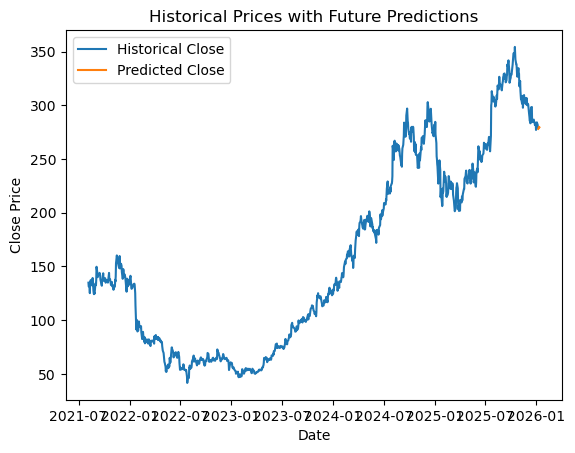

In [31]:
plt.figure()
plt.plot(df["Date"], df["Close"], label="Historical Close")
plt.plot(future_dates, future_predictions, label="Predicted Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Prices with Future Predictions")
plt.legend()
plt.show()

In [32]:
prediction_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions
})

prediction_df

,Date,Predicted_Close
0,2026-01-07 15:30:00,278.101189
1,2026-01-08 15:30:00,278.727755
2,2026-01-09 15:30:00,279.437490
3,2026-01-10 15:30:00,280.020121
4,2026-01-11 15:30:00,279.570772
